In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#BERT

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, Dataset
import numpy as np


In [4]:

df = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/sentiment_analysis.csv')  
df.head(5)


,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [6]:
df = df[['tweet', 'label']]  

# train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['tweet'], df['label'], test_size=0.3, stratify=df['label'], random_state=42
)
valid_texts, test_texts, valid_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Convert labels to a list
train_texts, valid_texts, test_texts = list(train_texts), list(valid_texts), list(test_texts)
train_labels, valid_labels, test_labels = list(train_labels), list(valid_labels), list(test_labels)

In [7]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, padding='max_length', truncation=True, max_length=self.max_len, return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128

train_dataset = SentimentDataset(train_texts, train_labels, tokenizer, max_len)
valid_dataset = SentimentDataset(valid_texts, valid_labels, tokenizer, max_len)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(df['label'])))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
num_epochs = 4
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * num_epochs)

criterion = torch.nn.CrossEntropyLoss()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [11]:
def train_model(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            total_loss += criterion(logits, labels).item()
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return total_loss / len(dataloader), predictions, true_labels

for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, optimizer, criterion)
    valid_loss, _, _ = evaluate_model(model, valid_loader, criterion)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss}, Validation Loss: {valid_loss}")


Epoch 1, Train Loss: 0.2456881353867801, Validation Loss: 0.2213000797231992
Epoch 2, Train Loss: 0.16018462686743104, Validation Loss: 0.21456908295551935
Epoch 3, Train Loss: 0.09823632759165545, Validation Loss: 0.23724190058807532
Epoch 4, Train Loss: 0.06565380433603842, Validation Loss: 0.30591312336424986


In [15]:
_, predictions, true_labels = evaluate_model(model, test_loader, criterion)


from sklearn.metrics import accuracy_score
print(f"Accuracy: {accuracy_score(true_labels, predictions):.4f}")
print(classification_report(true_labels, predictions))



Accuracy: 0.9150
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       884
           1       0.81      0.88      0.84       304

    accuracy                           0.91      1188
   macro avg       0.88      0.90      0.89      1188
weighted avg       0.92      0.91      0.92      1188



<Figure size 800x600 with 0 Axes>

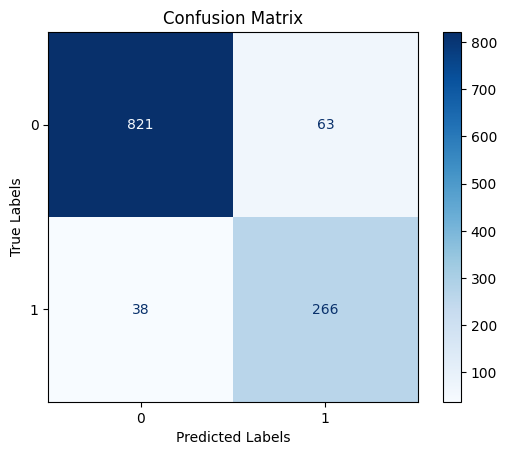

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay


conf_matrix = confusion_matrix(true_labels, predictions)


plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.config.id2label)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
#roberta

In [21]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
max_len = 128

train_dataset = SentimentDataset(train_texts, train_labels, tokenizer, max_len)
valid_dataset = SentimentDataset(valid_texts, valid_labels, tokenizer, max_len)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(set(df['label'])))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
num_epochs = 4
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * num_epochs)

criterion = torch.nn.CrossEntropyLoss()


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
def train_model(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            total_loss += criterion(logits, labels).item()
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return total_loss / len(dataloader), predictions, true_labels

for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, optimizer, criterion)
    valid_loss, _, _ = evaluate_model(model, valid_loader, criterion)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss}, Validation Loss: {valid_loss}")


Epoch 1, Train Loss: 0.2715321887574381, Validation Loss: 0.20992475221554438
Epoch 2, Train Loss: 0.19152640739740315, Validation Loss: 0.20898385494947433
Epoch 3, Train Loss: 0.15439357273065907, Validation Loss: 0.1974589493870735
Epoch 4, Train Loss: 0.1191541651372532, Validation Loss: 0.2390191572283705


In [25]:
_, predictions, true_labels = evaluate_model(model, test_loader, criterion)

# Accuracy and Classification Report
from sklearn.metrics import accuracy_score
print(f"Accuracy: {accuracy_score(true_labels, predictions):.4f}")
print(classification_report(true_labels, predictions))



Accuracy: 0.9074
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       884
           1       0.81      0.83      0.82       304

    accuracy                           0.91      1188
   macro avg       0.88      0.88      0.88      1188
weighted avg       0.91      0.91      0.91      1188



<Figure size 800x600 with 0 Axes>

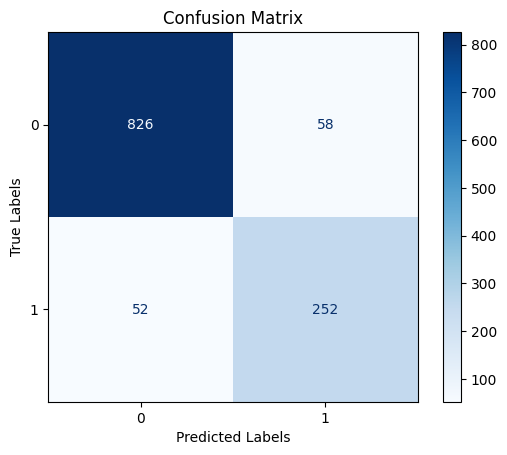

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay


conf_matrix = confusion_matrix(true_labels, predictions)

# Plot Confusion Matrix with numbers
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.config.id2label)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
